In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import seaborn as sns

import pickle
import igraph

/Users/davidlee/miniconda2/envs/py37/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
m_graph = pickle.load(open('./data/icwsm_polarization/mention_igraph.pickle', "rb"))
r_graph = pickle.load(open('./data/icwsm_polarization/retweet_igraph.pickle', "rb"))

In [3]:
all_graph = pickle.load(open('./data/icwsm_polarization/all_igraph.pickle', "rb"))

In [4]:
r_graph.edge_attributes()

['tags', 'type', 'urls', 'time']

In [5]:
r_graph.get_edgelist()[0:10]

[(12464, 7349),
 (6820, 12569),
 (4336, 15967),
 (16397, 5927),
 (8829, 13851),
 (17673, 5153),
 (5467, 3944),
 (9864, 2813),
 (15781, 5425),
 (1195, 6940)]

In [6]:
r_graph.es["tags"][0:10]

[['#tcot', '#tlot'],
 ['#p2', '#progca', '#casen'],
 ['#dems', '#ocra', '#p2', '#s'],
 ['#tcot'],
 ['#teaparty', '#tcot', '#alaska', '#ak'],
 ['#desen', '#tcot', '#teaparty'],
 ['#cuba', '#obama', '#eeuu'],
 ['#ocra', '#tcot'],
 ['#dems'],
 ['#tcot', '#teaparty', '#sgp']]

In [7]:
def reverse_igraph_edges(graph):
    edge_attributes = graph.edge_attributes()
    attributes_dict = {attr:r_graph.es[attr] for attr in edge_attributes}
    
    reversed_edges = [tuple(reversed(edge)) for edge  in graph.get_edgelist()]
    
    graph.es.delete()
    
    graph.add_edges(reversed_edges)
    
    for attr in edge_attributes:
        r_graph.es[attr] = attributes_dict[attr]


In [8]:
reverse_igraph_edges(r_graph)

In [9]:
r_graph.get_edgelist()[0:10]

[(7349, 12464),
 (12569, 6820),
 (15967, 4336),
 (5927, 16397),
 (13851, 8829),
 (5153, 17673),
 (3944, 5467),
 (2813, 9864),
 (5425, 15781),
 (6940, 1195)]

In [10]:
r_graph.es["tags"][0:10]

[['#tcot', '#tlot'],
 ['#p2', '#progca', '#casen'],
 ['#dems', '#ocra', '#p2', '#s'],
 ['#tcot'],
 ['#teaparty', '#tcot', '#alaska', '#ak'],
 ['#desen', '#tcot', '#teaparty'],
 ['#cuba', '#obama', '#eeuu'],
 ['#ocra', '#tcot'],
 ['#dems'],
 ['#tcot', '#teaparty', '#sgp']]

In [12]:
m_layout = m_graph.layout("large")

In [ ]:
r_layout=r_graph.layout("large")

In [5]:
m_graph.vs["size"]=4
m_graph.es["arrow_size"]=0.3
m_graph.es["width"]=0.5
m_graph.es["color"]="#b3b3b3"
color_dict = {"left": "#0015bc", "right": "#e91d0e", "-": "grey"}
m_graph.vs["color"] = [color_dict[cluster] for cluster in m_graph.vs["cluster"]]
m_out = igraph.plot(m_graph, layout=m_layout)

m_out.save("mention_network.png")

In [76]:
r_graph.vs["size"]=4
r_graph.es["arrow_size"]=0.3
r_graph.es["width"]=0.5
r_graph.es["color"]="#b3b3b3"
color_dict = {"left": "#0015bc", "right": "#e91d0e", "-": "grey"}
r_graph.vs["color"] = [color_dict[cluster] for cluster in r_graph.vs["cluster"]]
r_out = igraph.plot(r_graph, layout=r_layout)

r_out.save("retweet_network.png")

In [11]:
def plot_edge_distribution(ax, graph, mode, g_type):
    if (mode=="out" or mode=="in"):
        x = list(range(0, graph.maxdegree(mode=mode) + 1))
        y =[graph.degree(mode=mode).count(i) for i in x]

        ax.loglog(x, y, "k.")
        ax.set_xlabel("number of {}".format(g_type))
        ax.set_ylabel("number of users")

In [12]:
width = 12
height = width / 1.618

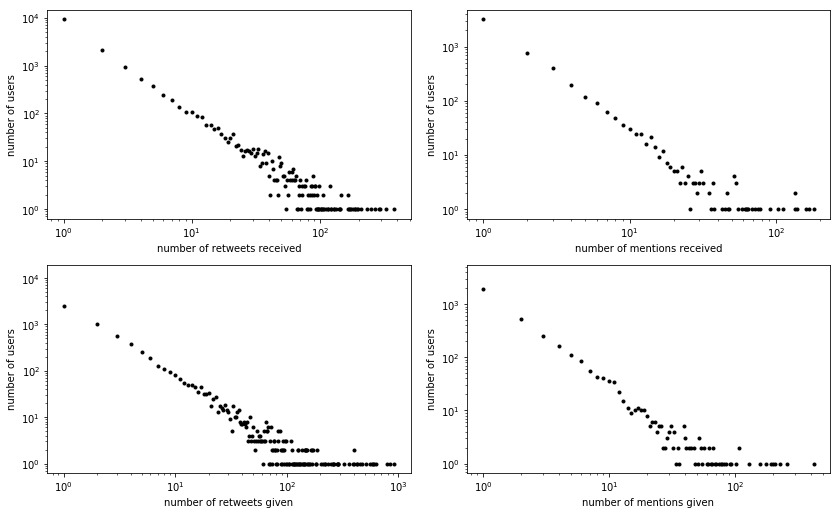

In [13]:
fig, ax = plt.subplots(2,2, figsize=(width, height))
fig.tight_layout(pad=2.5)
plot_edge_distribution(ax[0, 0], r_graph, "out", "retweets received")
plot_edge_distribution(ax[1, 0], r_graph, "in", "retweets given")
plot_edge_distribution(ax[0, 1], m_graph, "out", "mentions received")
plot_edge_distribution(ax[1, 1], m_graph, "in", "mentions given")
fig.savefig("edge_distributions.png", quality=95)

In [14]:
# Build vocabulary vector
# go through all of the edges in the edgelist. If a certain tag is used, then increment the entry in the tag.
# will need a dictionary that maps hashtags to indices in the vocabulary vector
# then going through the entire edgelist again, will need to look at the source (this is the actor)
# and will need to look at the tags associated with that tweet
# then going through each tag, find its appropriate index in the vector, and increment it for that actor


In [15]:
def get_tag_vocab(graph):
    tag2index = {}
    index = 0
    for taglist in graph.es["tags"]:
        for tag in taglist:
            if tag not in tag2index:
                tag2index[tag] = index
                index = index + 1

    return tag2index


In [16]:
vocab = get_tag_vocab(all_graph)

In [17]:
def get_bag_of_tags(graph, vocab):
    n_nodes = len(graph.vs)
    n_vocab = len(vocab)
    bag_of_tags = np.zeros((n_nodes, n_vocab))

    for i in range(len(graph.get_edgelist())):
        node_index = graph.es[i].source
        for tag in graph.es[i]['tags']:
            tag_index = vocab[tag]
            bag_of_tags[node_index][tag_index] += 1
            
    return bag_of_tags

In [18]:
bag_of_tags = get_bag_of_tags(all_graph, vocab)

In [19]:
# put into a pandas and perform PCA
tags_df = pd.DataFrame(data=bag_of_tags, columns=vocab.keys())

In [20]:
tags_df.head()

,#tcot,#memories4nov,#ocra,#dadt,#alaska,#ak,#aksen,#teaparty,#gop,#justsayin,...,#ronjohnson,#fearmongers,#opp,#joemilelr,#socialnetwork,#wilmd,#winwin7,#maloney,#hold,#camdengop
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# select top hashtags
tags_count = tags_df.sum(axis=0)
tags_count.head()

#tcot            37541.0
#memories4nov       25.0
#ocra             4432.0
#dadt             4206.0
#alaska            143.0
dtype: float64

In [22]:
tags_topN = tags_count.nlargest(n=20)

In [23]:
tags_topN.index

Index(['#tcot', '#p2', '#teaparty', '#gop', '#tlot', '#sgp', '#ocra', '#dadt',
       '#desen', '#obama', '#twisters', '#hhrs', '#nvsen',
       '#whyimvotingdemocrat', '#dems', '#p21', '#onenation', '#hcr',
       '#votedem', '#topprog'],
      dtype='object')

In [24]:
# get dataframe of only top 500
tags_df_topN = tags_df.loc[:, tags_topN.index]
tags_df_topN.head()

,#tcot,#p2,#teaparty,#gop,#tlot,#sgp,#ocra,#dadt,#desen,#obama,#twisters,#hhrs,#nvsen,#whyimvotingdemocrat,#dems,#p21,#onenation,#hcr,#votedem,#topprog
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


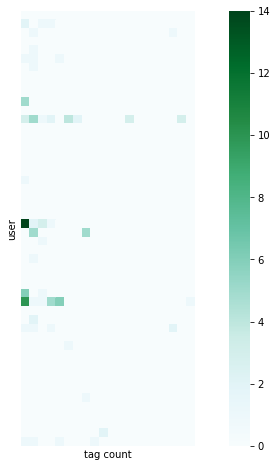

In [26]:
# generate heatmap
sns.heatmap(tags_df_topN.head(50), annot=False, cmap="BuGn", square=True, yticklabels=False, xticklabels=False)
fig = plt.gcf()
figsize=fig.get_size_inches()
fig.set_size_inches(figsize * 2)

plt.ylabel("user")
plt.xlabel("tag count")
fig.savefig("heatmap.png", quality=95)

In [35]:
norm_tags = pd.DataFrame(data=StandardScaler().fit_transform(tags_df), columns=vocab.keys())

In [36]:
norm_tags.head()

,#tcot,#memories4nov,#ocra,#dadt,#alaska,#ak,#aksen,#teaparty,#gop,#justsayin,...,#ronjohnson,#fearmongers,#opp,#joemilelr,#socialnetwork,#wilmd,#winwin7,#maloney,#hold,#camdengop
0,-0.121762,-0.008279,-0.038114,-0.027791,-0.013573,-0.013942,-0.045922,-0.103284,-0.064314,-0.03639,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681
1,0.023577,-0.008279,-0.038114,-0.027791,-0.013573,-0.013942,-0.045922,0.083125,0.140629,-0.03639,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681
2,-0.121762,-0.008279,-0.038114,-0.027791,-0.013573,-0.013942,-0.045922,-0.103284,-0.064314,-0.03639,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681
3,-0.121762,-0.008279,-0.038114,-0.027791,-0.013573,-0.013942,-0.045922,-0.103284,-0.064314,-0.03639,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681
4,-0.121762,-0.008279,-0.038114,-0.027791,-0.013573,-0.013942,-0.045922,-0.103284,-0.064314,-0.03639,...,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681,-0.006681


In [47]:
# Perform PCA
n_components = 100
columns = ["PC{}".format(n+1) for n in range(n_components)]
pca = PCA(n_components=n_components)
principal_tags = pd.DataFrame(data=pca.fit_transform(norm_tags), columns=columns)

In [48]:
principal_tags.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
0,-0.155325,-0.170603,-0.163788,-0.189927,-0.110691,-0.123065,-0.243192,-0.239728,-0.061741,-0.098772,...,0.041516,0.003732,0.059625,-0.055652,-0.006049,0.014241,-0.000756,-0.055597,-0.029338,0.005613
1,-0.106975,-0.055511,0.670416,-0.125508,-0.054613,-0.002551,0.432857,0.559422,-0.115344,-0.066304,...,0.079043,0.072219,0.313005,-0.096509,-0.479237,-0.144098,0.182378,-0.113677,-0.159783,0.291681
2,-0.102732,-0.140080,-0.164602,-0.164247,-0.113853,-0.121387,-0.242348,-0.229703,-0.061169,-0.092912,...,0.045708,0.003362,0.048088,-0.047509,-0.012427,0.019547,-0.009989,-0.049806,-0.035774,0.003827
3,-0.155325,-0.170603,-0.163788,-0.189927,-0.110691,-0.123065,-0.243192,-0.239728,-0.061741,-0.098772,...,0.041516,0.003732,0.059625,-0.055652,-0.006049,0.014241,-0.000756,-0.055597,-0.029338,0.005613
4,-0.146386,-0.156689,-0.157259,-0.143897,-0.096838,-0.077476,-0.175775,-0.102762,-0.024770,1.142830,...,0.074867,-0.033658,-0.031948,-0.214600,0.304927,0.203297,0.200752,0.054058,0.316456,-0.223229


In [65]:

print("variance explained by first {} principal components: {}".format(n_components, pca.explained_variance_ratio_.cumsum()[-1]))

variance explained by first 100 principal components: 0.26619069012738844


In [66]:
# Create full dataframe
label = pd.DataFrame(data=all_graph.vs["cluster"], columns=["label"])
label.head()

,label
0,right
1,right
2,left
3,left
4,-


In [67]:
principal_tags_full = pd.concat([principal_tags, label], axis=1)
principal_tags_full.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,label
0,-0.155325,-0.170603,-0.163788,-0.189927,-0.110691,-0.123065,-0.243192,-0.239728,-0.061741,-0.098772,...,0.003732,0.059625,-0.055652,-0.006049,0.014241,-0.000756,-0.055597,-0.029338,0.005613,right
1,-0.106975,-0.055511,0.670416,-0.125508,-0.054613,-0.002551,0.432857,0.559422,-0.115344,-0.066304,...,0.072219,0.313005,-0.096509,-0.479237,-0.144098,0.182378,-0.113677,-0.159783,0.291681,right
2,-0.102732,-0.140080,-0.164602,-0.164247,-0.113853,-0.121387,-0.242348,-0.229703,-0.061169,-0.092912,...,0.003362,0.048088,-0.047509,-0.012427,0.019547,-0.009989,-0.049806,-0.035774,0.003827,left
3,-0.155325,-0.170603,-0.163788,-0.189927,-0.110691,-0.123065,-0.243192,-0.239728,-0.061741,-0.098772,...,0.003732,0.059625,-0.055652,-0.006049,0.014241,-0.000756,-0.055597,-0.029338,0.005613,left
4,-0.146386,-0.156689,-0.157259,-0.143897,-0.096838,-0.077476,-0.175775,-0.102762,-0.024770,1.142830,...,-0.033658,-0.031948,-0.214600,0.304927,0.203297,0.200752,0.054058,0.316456,-0.223229,-


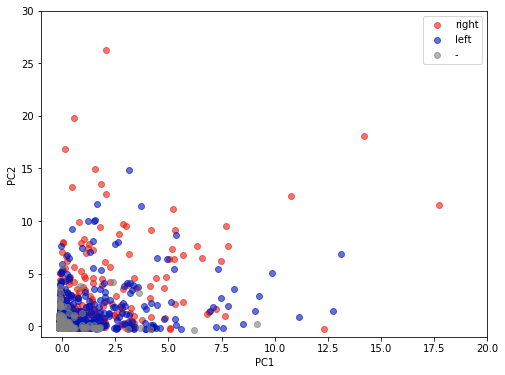

In [68]:
# plot with given labels
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
l = principal_tags_full["label"]
label_list = l.unique()
color_dict = {"left": "#0015bc", "right": "#e91d0e", "-": "grey"}
for target in label_list:
    target_indices = (l == target)
    ax.scatter(principal_tags_full.loc[target_indices, 'PC1']
              , principal_tags_full.loc[target_indices, 'PC2']
              , alpha=0.6, c=color_dict[target])
    ax.legend(label_list, loc='best')
    ax.set_xlim(-1,20)
    ax.set_ylim(-1,30)
    
fig.savefig("tags_pca.png", quality=95)

In [36]:
# k-means
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=5).fit(norm_tags)


In [38]:
clusters = pd.DataFrame(data=kmeans.labels_, columns=["label"])

In [45]:
clusters["label"]

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
22375    0
22376    0
22377    0
22378    0
22379    0
22380    0
22381    0
22382    0
22383    0
22384    0
22385    0
22386    0
22387    0
22388    0
22389    0
22390    0
22391    0
22392    0
22393    0
22394    0
22395    0
22396    0
22397    0
22398    0
22399    0
22400    0
22401    0
22402    0
22403    0
22404    0
Name: label, Length: 22405, dtype: int32

In [53]:
clusters["label"].unique()

array([0, 1])